In [10]:
## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import glob

import random 

In [11]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Dataset micrografías

In [12]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('/home/willy98/archivos/Datasets/SH_procesadas/Recortadas_grises/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


### Data Augmentation (Secas)

In [13]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)

In [14]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [15]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['MF1','MF2','MF3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 598 validated image filenames belonging to 3 classes.


In [16]:
X_train_secas_expanded = []
y_train_secas_expanded = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator.next()

    X_train_secas_expanded.extend(x)
    y_train_secas_expanded.extend(y)
    
print(np.shape(X_train_secas_expanded),np.shape(y_train_secas_expanded))

(2990, 128, 128, 1) (2990,)


(128, 128, 1)
0.007843138 0.882353


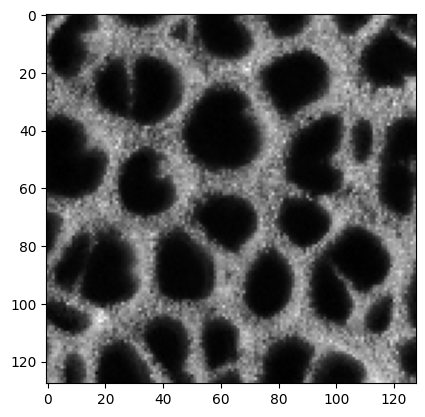

In [17]:
plt.imshow(X_train_secas_expanded[0],cmap='gray')
print(np.shape(X_train_secas_expanded[0]))
print(np.min(X_train_secas_expanded[0]),np.max(X_train_secas_expanded[0]))
plt.show()

In [18]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].routes
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (184, 128, 128, 1)  test -> (184,)


In [19]:
x_train_secas_expanded = np.array(X_train_secas_expanded)
x_test_secas = np.array(X_test_secas)

x_train_secas_expanded = x_train_secas_expanded.astype('float32')
x_test_secas= x_test_secas.astype('float32')
 
y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('x_train shape:', x_train_secas_expanded.shape)
print('Number of images in x_train', x_train_secas_expanded.shape[0], "y_train:", np.shape(y_train_secas_expanded))
print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

x_train shape: (2990, 128, 128, 1)
Number of images in x_train 2990 y_train: (2990,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184, 3)


### Construir modelo

In [ ]:
def downsample_block(x_input, n_filters):
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal',strides=1)(x_input)
    #x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    return x

def upsample_block(x_input, n_filters):
    x = tf.keras.layers.UpSampling2D()(x_input)
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x_input)
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    return x

def encoder_block(inputs,n_filters):
    conv_features = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(inputs)
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x)
    x = tf.keras.layers.concatenate([x,conv_features]) ### Cambiar por una suma
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    return x, x

def decoder_block(x_input,n_filters):
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x_input)
    conv_features = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)  ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(n_filters,3,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(n_filters,1,padding = 'same',activation = 'relu',kernel_initializer='HeNormal')(x)
    x = tf.keras.layers.concatenate([x,conv_features]) ### Cambiar por una suma
    x = tf.keras.layers.BatchNormalization()(x) ## Cambiar por Instance Normalization
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    return x

def build_unet_2_model():
    ## Inputs
    inputs = tf.keras.layers.Input(shape=(128,128,1))
    
    ## Encoder - capa 1     
    #e1, cf1 =  encoder_block(inputs,256)
    #a1 = downsample_block(e1,1)
    
    ## Encoder - capa 2
    e2, cf2 =  encoder_block(inputs,128)
    a2 = downsample_block(e2,128)
    
    ## Encoder - capa 3
    e3, cf3 =  encoder_block(a2,64)
    a3 = downsample_block(e3,64)
    
    ## Encoder - capa 4
    e4, cf4 =  encoder_block(a3,32)
    a4 = downsample_block(e4,64)
    
    ## Embebidos
    embedding, embedding_2 = encoder_block(x,16)
    
    # Decoder - Capa 4 
    u1 = upsample_block(embedding, 32)
    d1 = decoder_block(u1,32)
    d1 = tf.keras.layers.concatenate([d1,a4])
    
    # Decoder - Capa 3
    u2 = upsample_block(embedding, 64)
    d2 = decoder_block(u2,64)
    d2 = tf.keras.layers.concatenate([d1,a3])
    
    # Decoder - Capa 2
    u3 = upsample_block(embedding, 128)
    d3 = decoder_block(u3,128)
    d3 = tf.keras.layers.concatenate([d1,a2])
    
    # Decoder - Capa 1
    #u4 = upsample_block(embedding, 1)
    #d4 = decoder_block(u1,256)
    #d4 = tf.keras.layers.concatenate([d1,a1])
    
    ## Outputs
    outputs = decoder_block(d3,1)
    outputs = tf.keras.layers.Conv2D(1,(128,128))(outputs)
    
    
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

unet_model = build_unet_2_model()

unet_model.summary()
    

In [ ]:
unet_model = build_unet_2_model()

unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.000001),
                   loss=tf.keras.losses.BinaryCrossentropy())

model_history = unet_model.fit(x_train_expanded,x_train_expanded, epochs=20, 
                batch_size=32)

In [ ]:
np.shape(x_test)

In [ ]:
test_results = unet_model.predict(x_test[:10])

In [ ]:
np.shape((test_results[0]))